# Thermodynamic Feasibility and Sampling of Metabolite Concentrations
This notebook demonstrates how **MASSpy** is used to ensure thermodynamic feasibility in the metabolite concentrations of a model, and how samples of thermodynamically feasible metabolite concentrations are generated for a model.

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import mass.example_data

from mass import MassConfiguration
from mass.thermo import ConcSolver

MASSCONFIGURATION = MassConfiguration()

**Note**: Throughout this notebook, the term *thermodynamic feasibility constraint* for a reaction refers to the following:

For a given reaction:

$$
\textbf{S}^T \ln{(\textbf{x})} < \ln{(\text{Keq})}\ - \epsilon\ \text{if}\ \text{v}\ > 0\\
\textbf{S}^T \ln{(\textbf{x})} > \ln{(\text{Keq})}\ + \epsilon\ \text{if}\ \text{v}\ < 0\\
$$

where

* $\textbf{S}$ refers to the stoichiometry of the reaction
* $\textbf{x}$ refers to the vector of concentrations for the reaction metabolites
* $\text{Keq}$ refers to the equilibrium constant of the reaction
* $\text{v}$ refers to the reaction flux.
* $\epsilon$ refers to a buffer value for the constraint.

Based on methods outlined in <cite data-cite="KummelPH06">(Kummel et al., 2006)</cite> and <cite data-cite="HDR13">(Hamilton, et al., 2013)</cite>

## The ConcSolver Object

Upon initialization of the `ConcSolver` instance, the model becomes associated with the `ConcSolver` instance.
Metabolite concentrations and reaction equilibrium constants are added as variables to the `ConcSolver`.Thermodynamic feasibility constraints, based on the reaction's flux direction and stoichiometry, are created and also added to the solver. **All solver variables and constraints exist in logarithmic space.**

Metabolite concentrations that should be excluded from the solver can be defined using the `exclude_metabolites` argument (e.g., hydrogen and water). Reactions can also be excluded from the solver using the `exclude_reactions` argument.

Reactions that should exist at equilibrium or equilibrate very quickly should be set using the `equilibrium_reactions` argument. These reactions, such as the hemoglobin binding reactions and the adenylate kinase (ADK1) reaction, typically have a steady state flux value of 0.

In [2]:
# Load the JSON version of the textbook model
model = mass.example_data.create_example_model("textbook")

Set parameter Username


In [3]:
conc_solver = ConcSolver(
    model,
    excluded_metabolites=["h_c", "h2o_c"],
    excluded_reactions=None,
    equilibrium_reactions=["HBDPG", "HBO1", "HBO2", "HBO3", "HBO4", "ADK1",
                           "PFK_L"])
# View the model in the ConcSolver
conc_solver.model

Name,RBC_PFK
Memory address,0x07f7cf009bee0
Stoichiometric Matrix,68x76
Matrix Rank,63
Number of metabolites,68
Initial conditions defined,68/68
Number of reactions,76
Number of genes,0
Number of enzyme modules,1
Number of groups,16
Objective expression,0


The `ConcSolver` also becomes associated with the loaded model.

In [4]:
print(model.conc_solver)

<ConcSolver RBC_PFK at 0x7f7d20c210d0>


Concentrations and equilibrium constants cannot be negative numbers; therefore, the bounds for each variable are set to ensure such behavior. Because $\ln(0)$ results in a domain error, the `ConcSolver` has the `zero_value_log_substitute` attribute. The value of the attribute is substituted for 0 to avoid any errors.

For example, if `zero_value_log_substitute=1e-10`, then taking the logarithm of 0 is treated as $\ln(0) \approx \ln(1*10^{-10}) = -23.026$.

In [5]:
print("Substitute for ln(0): ln({0:.1e})".format(
    conc_solver.zero_value_log_substitute))

Substitute for ln(0): ln(1.0e-10)


Variables can be accessed through the `variables` attribute. The number of variables equals the combined total of  the number of included metabolites and the number of included reactions. Specific variables can be accessed using their identifiers as a key.

In [6]:
print("Number of included metabolites: {0}".format(len(conc_solver.included_metabolites)),
      "\nNumber of included reactions: {0}".format(len(conc_solver.included_reactions)),
      "\nTotal number of variables: {0}\n".format(len(conc_solver.variables)))

# Access the glucose concentration variable
variable = conc_solver.variables["glc__D_c"]
print("The glucose concentration variable",
      "\n----------------------------------\n",
      variable)

Number of included metabolites: 66 
Number of included reactions: 48 
Total number of variables: 114

The glucose concentration variable 
----------------------------------
 -23.025850929940457 <= glc__D_c <= inf


Constraints can be accessed through the `constraints` attribute. The number of constraints equals the number of included reactions. Just like variables, specific constraints can be accessed using reaction identifiers as a key.

In [7]:
print("Total number of constraints: {0}\n".format(len(conc_solver.constraints)))
# Access the hexokinase thermodynamic feasibility constraint
print("Thermodynamic feasibility constraint for HEX1",
      "\n-------------------------------------------\n",
      conc_solver.constraints["HEX1"])

Total number of constraints: 48

Thermodynamic feasibility constraint for HEX1 
-------------------------------------------
 HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= 0


Currently, the constraints do not have an error buffer, which provides some flexibility when solving the underlying mathematical problem of the `ConcSolver`. The `constraint_buffer` attribute can be used to set the *epsilon* value of the constraint. The constraints must be reset in order for the changed buffer value to take effect.

In [8]:
conc_solver.constraint_buffer = 1e-7
conc_solver.reset_constraints()
print("Thermodynamic feasibility constraint for HEX1",
      "\n-------------------------------------------\n",
      conc_solver.constraints["HEX1"])

Thermodynamic feasibility constraint for HEX1 
-------------------------------------------
 HEX1: -1.0*Keq_HEX1 + 1.0*adp_c - 1.0*atp_c + 1.0*g6p_c - 1.0*glc__D_c <= -1e-07


Upon initialization of the `ConcSolver`, the `ConcSolver.problem_type` is considered generic and no objective is set.

In [9]:
print(conc_solver.problem_type)
print(conc_solver.objective)

generic
Maximize
0


The following sections demonstrate different types of problems that can be solved using the `ConcSolver`.

## Solving for Feasible Concentrations
### Creating the QP problem

In order to determine thermodynamically feasible concentrations, a quadratic programming (QP) problem can be set up as follows:

Minimize
$$\ln( (\textbf{x}/\textbf{x}_0)^{2} )$$

subject to

$$
\textbf{S}^T \ln{(\textbf{x})} \lt \ln{(\text{Keq}_i)}\ - \epsilon\ \text{if}\ \text{v}_i\ \gt 0 \\
\textbf{S}^T \ln{(\textbf{x})} \gt \ln{(\text{Keq}_i)}\ + \epsilon\ \text{if}\ \text{v}_i\ \lt 0 \\
\ln(\text{Keq}_{i,\ lb}) \leq \ln(\text{Keq}_i) \leq \ln(\text{Keq}_{i,\ ub}) \\
\ln(\text{x}_{j,\ lb}) \leq \ln(\text{x}_j) \leq \ln(\text{x}_{j,\ ub}) \\
$$

where 

* $\textbf{S}$ refers to the stoichiometric matrix.
* $\textbf{x}$ refers to the vector of metabolite concentrations.
* $\textbf{x}_0$ refers to the vector of initial metabolite concentrations.
* $\text{Keq}_i$ refers to the equilibrium constant of reaction $i$.
* $\text{v}_i$ refers to the flux for reaction $i$.
* $\text{x}_j$ refers to the concentration of metabolite $j$.
* $\epsilon$ refers to a buffer value for the constraint.

Note that solving the QP problem requires a capable solver. Although **MASSpy** does not come with any QP solvers installed, it can interface with an installed version of [gurobi](https://www.gurobi.com/) through the **optlang** package.

The first step is to set the optimization solver to one that is capable of handling quadratic objectives. 

In [10]:
conc_solver.solver = conc_solver.choose_solver(qp=True)
print(repr(conc_solver.solver))

To set up the underlying mathematical problem in the `ConcSolver`, the `setup_feasible_qp_problem()` method can be used. The `fixed_conc_bounds` and `fixed_Keq_bounds` arguments can be used to set the upper and lower bounds of the corresponding variables equal to one other, fixing the variable's value. In this example, the metabolite concentrations are allowed to change, while the equilibrium constants are fixed at their original value.

In [11]:
conc_solver.setup_feasible_qp_problem(
    fixed_Keq_bounds=conc_solver.model.reactions)

Using the `setup_feasible_qp_problem()` method also sets the objective for the optimization.

In [12]:
print(conc_solver.objective_direction)
conc_solver.objective

min


After using the `setup_feasible_qp_problem()` method, the `ConcSolver` is ready for optimization. The `problem_type` is automatically changed to reflect the current problem setup.

In [13]:
print(conc_solver.problem_type)

feasible_qp


### The ConcSolution Object
Once the `ConcSolver` is set up to solve the QP, the next step is to use the `optimize()` method to solve the QP. A successful optimization returns a `ConcSolution` object. All values are transformed back into linear space upon being returned.

In [14]:
conc_solution = conc_solver.optimize()
conc_solution

,variables,reduced_costs
glc__D_c,1.296763,0.000000
g6p_c,0.165018,0.000000
f6p_c,0.067532,0.000000
fdp_c,0.016615,0.000000
dhap_c,0.169711,0.000000
...,...,...
Keq_PFK_L,0.001100,-0.103955
Keq_PFK_T1,10.000000,-1.097455
Keq_PFK_T2,10.000000,-0.408917
Keq_PFK_T3,10.000000,0.000000


The `ConcSolution` object has several methods for viewing the results of the optimization and returning `pandas` objects containing the numerical solutions.

In [15]:
dir(conc_solution)

['Keq_reduced_costs',
 'Keqs',
 'Keqs_to_frame',
 'concentration_reduced_costs',
 'concentrations',
 'concentrations_to_frame',
 'get_primal_by_id',
 'objective_value',
 'shadow_prices',
 'status',
 'to_frame']

In [16]:
from mass.visualization import plot_comparison

Through visualization features of **MASSPy**, the predicted values can be plotted against the original model values for comparison using the `plot_comparison()` function.

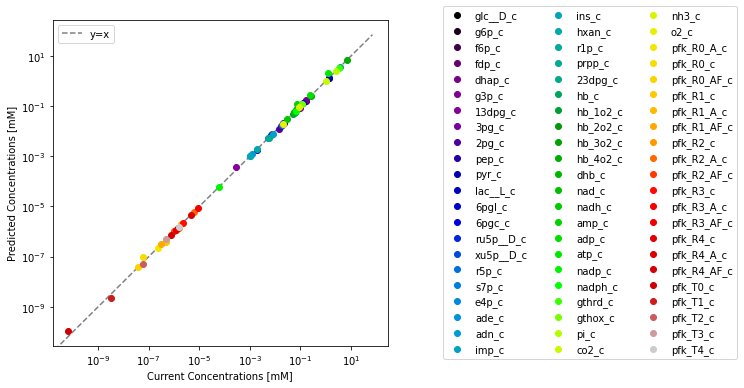

In [17]:
# Create figure
fig, ax = plt.subplots(figsize=(6, 6))

# Compare values
plot_comparison(
    x=model, y=conc_solution, compare="concentrations",
    observable=conc_solver.included_metabolites, legend="right outside",
    xlabel="Current Concentrations [mM]",
    ylabel="Predicted Concentrations [mM]",
    plot_function="loglog", xy_line=True, xy_legend="best");

The model in the `ConcSolver` can be updated with the results contained within the `ConcSolution` using the `update_model_with_solution()` method. Setting `inplace=True` updates the current model in the `ConcSolver`, while setting `inplace=False` replaces the model in the `ConcSolver` with an updated copy the model without modifying the original. Setting `inplace=False` also removes the previous model's association with the `ConcSolver`.

In [18]:
conc_solver.update_model_with_solution(
    conc_solution, concentrations=True, Keqs=False, inplace=False)
print("Same model object? {0}".format(conc_solver.model == model))
print(model.conc_solver)

Same model object? False
None


## Concentration Sampling
### Basic usage

The easiest method of sampling concentrations is to use the `sample_concentrations()` function in the `conc_sampling` submodule.

In [19]:
from mass.thermo.conc_sampling import sample_concentrations

To set up the `ConcSolver` for sampling, the `setup_sampling_problem` method is used. The `conc_percent_deviation` and `Keq_percent_deviation` arguments can be used to set the variable bounds for sampling. For this example, the defined concentrations are allowed to deviate up to %75 from their baseline value, while the defined equilibrium constants remain fixed at their current values. 

In [20]:
conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.75,
    Keq_percent_deviation=0)
print(conc_solver.problem_type)

sampling


Using the `sample_concentrations()` function requires at least two arguments: a `ConcSolver` that has been set up for sampling, and the number of samples to generate.

In [21]:
samples = sample_concentrations(conc_solver, n=20)
samples.head()

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,...,pfk_R3_A_c,pfk_R3_AF_c,pfk_R4_c,pfk_R4_A_c,pfk_R4_AF_c,pfk_T0_c,pfk_T1_c,pfk_T2_c,pfk_T3_c,pfk_T4_c
0,1.776031,0.225999,0.089964,0.020589,0.154565,0.008504,0.000416,0.102543,0.011834,0.020057,...,0.000014,2.261391e-06,1.888078e-06,0.000007,3.013082e-07,4.227295e-11,9.171097e-10,1.284325e-08,1.304504e-07,3.808015e-07
1,1.584736,0.219790,0.087706,0.018811,0.137524,0.006709,0.000414,0.082037,0.010206,0.014495,...,0.000006,9.566485e-07,7.988064e-07,0.000003,2.393127e-07,4.203981e-11,7.653907e-10,1.484397e-08,1.450826e-07,4.380999e-07
2,1.476564,0.203249,0.075462,0.016502,0.122260,0.006041,0.000394,0.070950,0.009434,0.013528,...,0.000005,8.413586e-07,6.497424e-07,0.000002,2.212789e-07,3.343054e-11,6.646832e-10,1.393792e-08,1.401509e-07,4.242574e-07
3,1.611821,0.218186,0.078626,0.015716,0.117922,0.006131,0.000429,0.045345,0.006051,0.008962,...,0.000005,1.109585e-06,8.686517e-07,0.000003,3.090001e-07,4.128989e-11,7.914225e-10,1.757626e-08,1.561635e-07,4.600968e-07
4,2.148799,0.261852,0.100766,0.008254,0.068786,0.003777,0.000408,0.029591,0.004135,0.006085,...,0.000006,1.097732e-06,1.088903e-06,0.000003,5.549445e-07,6.531665e-11,1.573526e-09,4.263682e-08,2.259306e-07,6.118950e-07


By default `sample_concentrations` uses the `optgp` method <cite data-cite="MHM14">
(Megchelenbrink, Huynen, and Marchiori, 2014)</cite>, as it is suited for larger models and can run in parallel. The number of processes can be changed by using the `processes` argument.

In [22]:
print("One process:")
%time samples = sample_concentrations(conc_solver, n=1000, processes=1)
print("\nTwo processes:")
%time samples = sample_concentrations(conc_solver, n=1000, processes=2)

One process:
CPU times: user 12.7 s, sys: 357 ms, total: 13.1 s
Wall time: 11.7 s

Two processes:
CPU times: user 695 ms, sys: 199 ms, total: 895 ms
Wall time: 9.44 s


Alternatively, the Artificial Centering Hit-and-Run for sampling <cite data-cite="KS98">
(Kaufman and Smith, 1998)</cite> can be utilized by setting the method to `achr`. The `achr` method does not support parallel execution, but it has good convergence and is almost Markovian.

In [23]:
samples = sample_concentrations(conc_solver, n=100, method="achr")

In general, setting up the sampler is expensive since initial search directions are generated by solving many linear programming problems. Thus, it is recommended to generate as many samples as possible in one go. However, generating large numbers of samples might require finer control over the sampling procedure, as described in the following section.

### Advance usage
#### Sampler objects

The concentration sampling process can be controlled on a lower level by using the sampler classes directly, found in the `conc_sampling` submodule.

In [24]:
from mass.thermo.conc_sampling import ConcACHRSampler, ConcOptGPSampler

Both concentration sampler classes have standardized interfaces and take some additional arguments. 

For example, one such argument is the thinning factor, where “thinning” means only recording samples every `x` iterations where `x` is the thinning factor. Higher thinning factors mean less correlated samples but also larger computation times.

By default, the samplers use a thinning factor of 100, which creates roughly uncorrelated samples. Increasing the thinning factor leads to better mixing of samples, while lowering the thinning factor leads to more correlated samples. For example, it may be desirable to set a thinning factor of 1 to obtain all iterates when studying convergence for a model.

Samplers can be seeded so that they produce the same results each time they are run.

In [25]:
conc_achr = ConcACHRSampler(conc_solver, thinning=1, seed=5)
samples = conc_achr.sample(10, concs=True)
# Display only the first 5 samples
samples.head(5)

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,...,pfk_R3_A_c,pfk_R3_AF_c,pfk_R4_c,pfk_R4_A_c,pfk_R4_AF_c,pfk_T0_c,pfk_T1_c,pfk_T2_c,pfk_T3_c,pfk_T4_c
0,1.592336,0.197568,0.078832,0.018910,0.142081,0.007510,0.000472,0.090709,0.013006,0.021494,...,0.000003,4.536657e-07,3.693232e-07,0.000001,2.228541e-07,3.305772e-11,6.624519e-10,1.327504e-08,1.311206e-07,3.905462e-07
1,2.248172,0.285898,0.116922,0.004324,0.043806,0.002030,0.000364,0.022330,0.003282,0.005558,...,0.000002,3.634455e-07,3.032560e-07,0.000001,1.922307e-07,2.714412e-11,5.768461e-10,1.225869e-08,1.236426e-07,3.810419e-07
2,2.263896,0.288041,0.117857,0.004522,0.045433,0.002117,0.000370,0.023388,0.003439,0.005827,...,0.000002,3.618207e-07,3.020507e-07,0.000001,1.916574e-07,2.703623e-11,5.752355e-10,1.223898e-08,1.234960e-07,3.808523e-07
3,2.258775,0.287343,0.117552,0.004406,0.044485,0.002067,0.000366,0.022777,0.003348,0.005673,...,0.000002,3.623478e-07,3.024418e-07,0.000001,1.918435e-07,2.707124e-11,5.757583e-10,1.224538e-08,1.235436e-07,3.809139e-07
4,2.267224,0.288494,0.109154,0.004331,0.043882,0.002036,0.000365,0.022409,0.003295,0.005585,...,0.000002,3.614792e-07,3.017973e-07,0.000001,1.915368e-07,2.701355e-11,5.748966e-10,1.223483e-08,1.234651e-07,3.808123e-07


The `sample()` method also comes with the `concs` argument that controls the sample output. Setting `concs=True` returns only concentration variables, while setting `concs=False` returns the equilibrium constant variables and any additional variables.

In [26]:
samples = conc_achr.sample(10, concs=False)
print(samples.columns)

Index(['ade_c', 'adn_c', 'imp_c', 'prpp_c', 'nh3_c', 'glc__D_c', 'g6p_c',
       'adp_c', 'atp_c', 'Keq_HEX1',
       ...
       'pfk_T0_c', 'Keq_PFK_L', 'pfk_T1_c', 'Keq_PFK_T1', 'pfk_T2_c',
       'Keq_PFK_T2', 'pfk_T3_c', 'Keq_PFK_T3', 'pfk_T4_c', 'Keq_PFK_T4'],
      dtype='object', length=114)


The `ConcOptGPSampler` has an additional `processes` argument that specifies how many processes are used to create parallel sampling chains. The number of processes should be in the order of available CPU cores for maximum efficiency. As noted before, the class initialization can take up to a few minutes due to generation of initial search directions. On the other hand, sampling is quicker.

In [27]:
conc_optgp = ConcOptGPSampler(conc_solver, processes=4, seed=5)

For the `ConcOptGPSampler`, the number of samples should be a multiple of the number of processes. Otherwise, the number is increased automatically to the nearest multiple.

In [28]:
samples = conc_optgp.sample(10)
print("Number of samples generated: {0}".format(len(samples)))

Number of samples generated: 12


#### Batch sampling

Sampler objects are made for generating billions of samples, however using the sampling functions might quickly fill up the computer RAM when working with genome-scale models. 

In this scenario, the batch method of the sampler objects might be useful. The `batch` method takes two arguments: the number of samples in each batch and the number of batches.

Suppose the concentration of ATP, ADP and AMP are unknown. The batch sampler could be used to generate 10 batches of feasible concentrations with 100 samples each. The samples could be averaged to get the mean metabolite concentrations per batch. Finally, the mean metabolite concentrations and standard deviation could be calculated.

In [29]:
# Remove current initial conditions for example
conc_solver.model.metabolites.atp_c.ic = None
conc_solver.model.metabolites.adp_c.ic = None
conc_solver.model.metabolites.amp_c.ic = None
# Set up concentration sampling problem
conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.5,
    Keq_percent_deviation=0)

# Get batch samples
conc_optgp = ConcOptGPSampler(conc_solver, processes=1, seed=5)
batch_samples = [sample for sample in conc_optgp.batch(100, 10)]

# Determine average metabolite concentrations per batch
for met in ["atp_c", "adp_c", "amp_c"]:
    met = conc_solver.model.metabolites.get_by_id(met)
    per_batch_axp_ave = [
        np.mean(sample[met.id])
        for sample in batch_samples]
    print("Ave. {2} concentration: {0:.5f} +- {1:.5f}".format(
        np.mean(per_batch_axp_ave), np.std(per_batch_axp_ave), met.id))
    met.ic = np.mean(per_batch_axp_ave)

Ave. atp_c concentration: 2.17516 +- 0.10551
Ave. adp_c concentration: 0.24789 +- 0.01742
Ave. amp_c concentration: 0.12479 +- 0.00738
